##  Clasificación de Texto con LSTM y Embeddings Preentrenados

### Instalando y cargando librerías

#### Instalación de Bibliotecas para Procesamiento de Lenguaje Natural y Aprendizaje Automático
Se instalan las bibliotecas gensim, nltk y tensorflow, que permiten trabajar con modelos de lenguaje, procesamiento de texto y redes neuronales en Python


In [141]:
%pip install gensim
%pip install nltk
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.


#### Gestión de Versiones de Bibliotecas Numéricas en Python

Se desinstala la versión actual de numpy y se instala la versión específica 1.24.4 para garantizar compatibilidad con otros paquetes. Además, se eliminan las bibliotecas jax y jaxlib que pueden generar conflictos con ciertas configuraciones numéricas o de aprendizaje automático.

In [142]:
%pip uninstall -y numpy
%pip install numpy==1.24.4
%pip uninstall -y jax jaxlib

Found existing installation: numpy 2.1.3
Uninstalling numpy-2.1.3:
  Successfully uninstalled numpy-2.1.3
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.Collecting numpy==1.24.4
  Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl (14.8 MB)



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


In [143]:
import pandas as pd
import numpy as np
import gensim # para cargar modelo w2v
import nltk

In [144]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt
import re
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FranklinManuel09\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Carga de datos


In [99]:
df = pd.read_csv(r"C:\Users\FranklinManuel09\Downloads\deceptive-opinion.csv")
df = df[['text', 'polarity']]
df['label'] = df['polarity'].map({'positive': 1, 'negative': 0})
df.head()

,text,polarity,label
0,We stayed for a one night getaway with family ...,positive,1
1,Triple A rate with upgrade to view room was le...,positive,1
2,This comes a little late as I'm finally catchi...,positive,1
3,The Omni Chicago really delivers on all fronts...,positive,1
4,I asked for a high floor away from the elevato...,positive,1


 ### Limpieza y análisis básico del texto 
 En esta sección se define y aplica una función de limpieza de texto sobre las reseñas hoteleras. El proceso incluye convertir todo a minúsculas, eliminar números, signos de puntuación y palabras vacías (stopwords) en inglés. Luego, se calcula la longitud de cada texto limpio en número de palabras. Finalmente, se muestra un ejemplo de cómo quedaron los textos después del preprocesamiento

In [100]:
# Función para limpiar el texto
def clean_text(text):
    """
    Limpia un texto eliminando números, puntuación y palabras vacías (stopwords),
    y convierte todo el texto a minúsculas.
    """
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r"\d+", "", text)  # Eliminar dígitos
    text = text.translate(str.maketrans("", "", string.punctuation))  # Eliminar puntuación
    tokens = text.split()  # Dividir en palabras
    tokens = [w for w in tokens if w not in stopwords.words('english')]  # Eliminar stopwords
    return " ".join(tokens)  # Unir de nuevo en una sola cadena

# Aplicar limpieza a la columna 'text' del DataFrame y guardar en una nueva columna 'clean_text'
df['clean_text'] = df['text'].apply(clean_text)

# Calcular la longitud (número de palabras) de cada texto limpio
text_lengths = df['clean_text'].apply(lambda x: len(x.split()))

# Mostrar algunos ejemplos para ver cómo quedaron los textos originales, limpiados y sus longitudes
df['text_length'] = text_lengths  # Añadir la longitud como una nueva columna al DataFrame

# Mostrar las primeras filas con el texto original, el texto limpio y la longitud del texto limpio
print(df[['text', 'clean_text', 'text_length']].head())


                                                text  \
0  We stayed for a one night getaway with family ...   
1  Triple A rate with upgrade to view room was le...   
2  This comes a little late as I'm finally catchi...   
3  The Omni Chicago really delivers on all fronts...   
4  I asked for a high floor away from the elevato...   

                                          clean_text  text_length  
0  stayed one night getaway family thursday tripl...           56  
1  triple rate upgrade view room less also includ...           30  
2  comes little late im finally catching reviews ...          107  
3  omni chicago really delivers fronts spaciousne...           64  
4  asked high floor away elevator got room pleasa...           34  


### Visualización de la distribución de la longitud de las reseñas

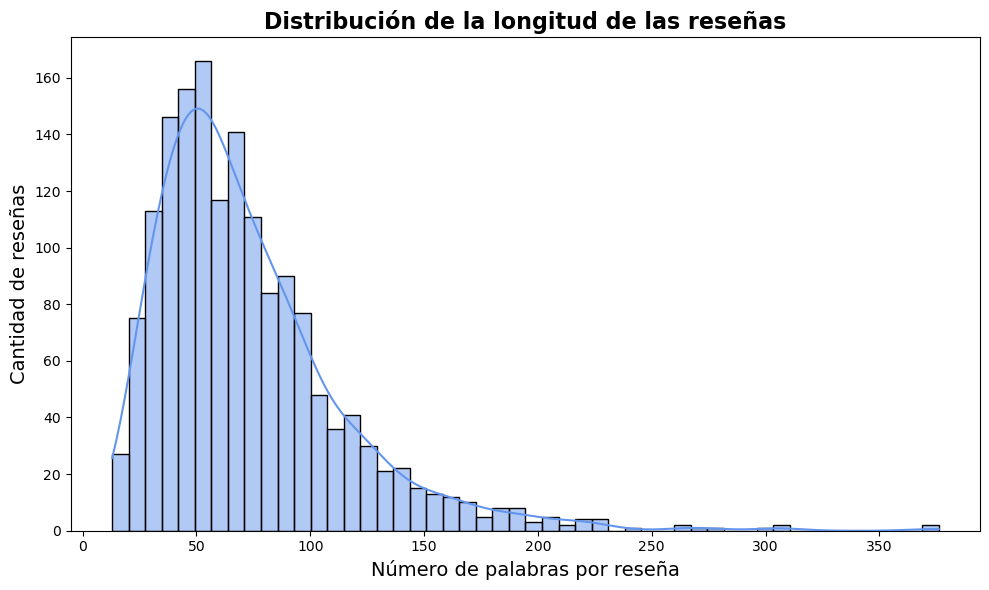

In [101]:
import seaborn as sns

plt.figure(figsize=(10,6))

sns.histplot(text_lengths, bins=50, kde=True, color='cornflowerblue')

plt.xlabel("Número de palabras por reseña", fontsize=14)
plt.ylabel("Cantidad de reseñas", fontsize=14)
plt.title("Distribución de la longitud de las reseñas", fontsize=16, fontweight='bold')

plt.tight_layout()

plt.show()


###  Resumen estadístico y cálculo del percentil 95 de las longitudes
En esta sección se imprimen las estadísticas descriptivas (conteo, media, desviación estándar, percentiles y valores extremos) de la longitud de los textos ya limpiados. Posteriormente, se calcula de forma exacta el percentil 95, que indica el número máximo de palabras que abarca al 95 % de las reseñas. Este valor es útil para decidir la longitud de secuencia (MAX_LEN) al aplicar padding o truncado en modelos de NLP, equilibrando cobertura y eficiencia computacional.

In [102]:
# Ver el resumen estadístico de las longitudes
print(text_lengths.describe())

# Calcular el percentil 95 (de forma precisa)
import numpy as np
max_len_95 = int(np.percentile(text_lengths, 95))
print("Longitud que cubre el 95% de los textos:", max_len_95)


count    1600.000000
mean       72.885000
std        42.176843
min        13.000000
25%        44.750000
50%        63.500000
75%        90.000000
max       376.000000
Name: clean_text, dtype: float64
Longitud que cubre el 95% de los textos: 154


###  Preparación de secuencias de texto para modelado: tokenización y padding
En esta sección se transforma el texto limpio en secuencias numéricas para que puedan ser procesadas por redes neuronales. Se utiliza un tokenizador para asignar un entero a cada palabra, se convierten los textos a secuencias de tokens y se aplica padding para que todas las secuencias tengan la misma longitud (MAX_LEN = 154), valor determinado previamente por el percentil 95 de la longitud de las reseñas.
También se muestra el diccionario de mapeo word_index (palabra → token) y se proporciona una función auxiliar para convertir tokens nuevamente a palabras con fines de interpretación

In [123]:
# Establecemos la longitud máxima de secuencias para el padding
# Elegimos 300 porque cubre el 95% de las reseñas según el análisis de longitud
MAX_LEN = 154

# Inicializamos el tokenizador
tokenizer = Tokenizer()

# Ajustamos el tokenizador al corpus de texto limpio
tokenizer.fit_on_texts(df['clean_text'])

# Convertimos los textos limpios a secuencias de enteros (tokens)
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Obtenemos el índice de palabras (diccionario: palabra → número entero)
word_index = tokenizer.word_index

# Aplicamos padding a las secuencias para que todas tengan la misma longitud
# Usamos padding al inicio ('pre') para que las palabras más recientes queden al final
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='pre')

# Extraemos las etiquetas (variable objetivo)
y = df['label'].values


In [125]:
#Mostrar el diccionario palabra → token
print("Diccionario word_index (palabra → token):")
print(word_index)

# Función para convertir una secuencia de tokens a palabras usando word_index inverso
index_word = {v: k for k, v in word_index.items()}  # Invertir diccionario

def tokens_a_palabras(secuencia):
    return [index_word.get(token, "?") for token in secuencia]

# Ejemplo: convertir la primera secuencia tokenizada de vuelta a palabras
print("\nPrimera secuencia de tokens:")
print(sequences[0])

print("\nPrimera secuencia convertida a palabras:")
print(tokens_a_palabras(sequences[0]))



Diccionario word_index (palabra → token):
{'hotel': 1, 'room': 2, 'chicago': 3, 'stay': 4, 'would': 5, 'great': 6, 'staff': 7, 'service': 8, 'one': 9, 'rooms': 10, 'stayed': 11, 'us': 12, 'night': 13, 'like': 14, 'get': 15, 'time': 16, 'desk': 17, 'nice': 18, 'location': 19, 'even': 20, 'could': 21, 'bed': 22, 'also': 23, 'clean': 24, 'good': 25, 'got': 26, 'back': 27, 'front': 28, 'place': 29, 'first': 30, 'hotels': 31, 'bathroom': 32, 'experience': 33, 'day': 34, 'next': 35, 'well': 36, 'didnt': 37, 'really': 38, 'two': 39, 'friendly': 40, 'never': 41, 'made': 42, 'comfortable': 43, 'go': 44, 'recommend': 45, 'business': 46, 'lobby': 47, 'staying': 48, 'view': 49, 'much': 50, 'city': 51, 'floor': 52, 'better': 53, 'check': 54, 'area': 55, 'food': 56, 'went': 57, 'called': 58, 'breakfast': 59, 'arrived': 60, 'definitely': 61, 'price': 62, 'best': 63, 'say': 64, 'weekend': 65, 'restaurant': 66, 'told': 67, 'everything': 68, 'found': 69, 'small': 70, 'helpful': 71, 'trip': 72, 'free': 7

### Carga del modelo word2vec y creamos la matriz de vectores
En esta sección se utiliza el modelo Word2Vec preentrenado (GoogleNews-vectors-negative300.bin) para representar las palabras del corpus con vectores densos de 300 dimensiones.
Se construye una matriz de embeddings (embedding_matrix) donde cada fila corresponde al vector de una palabra del vocabulario (word_index). Si una palabra del corpus no se encuentra en el modelo Word2Vec, se asigna un vector de ceros.

Este paso permite aprovechar conocimiento semántico previamente aprendido y mejorar la capacidad del modelo de comprender relaciones entre palabras

In [126]:

w2v_path = r'C:\Users\FranklinManuel09\Downloads\GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in w2v:
        embedding_matrix[i] = w2v[word]

### Creación del modelo LSTM con Word2Vec

Se construye un modelo secuencial que clasifica reseñas usando una red **LSTM**.

- Se usa una capa de **embedding** con vectores **Word2Vec** preentrenados, que no se modifican durante el entrenamiento.
- Luego, una capa **LSTM** aprende las relaciones entre las palabras.
- La capa final es una neurona con activación **sigmoide** para predecir si una reseña es positiva o negativa.
- El modelo se compila con el optimizador **Adam** y se mide la **precisión**.


In [145]:
# Definición del modelo secuencial
model = Sequential()

# Capa de Embedding:
# - input_dim: tamaño del vocabulario (número total de palabras + 1)
# - output_dim: dimensión del espacio de embedding (EMBEDDING_DIM)
# - weights: matriz de embeddings preentrenados
# - input_length: longitud máxima de las secuencias de entrada
# - trainable=False: los pesos no se actualizan durante el entrenamiento
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_LEN,
                    trainable=False))

# Capa LSTM:
# - EMBEDDING_DIM: unidades LSTM (puedes ajustarlo)
# - dropout=0.2: tasa de desactivación de neuronas para reducir el sobreajuste
model.add(LSTM(EMBEDDING_DIM, dropout=0.2))

# Capa de salida:
# - Dense(1): una sola neurona de salida (para clasificación binaria)
# - activation='sigmoid': función sigmoide para producir una probabilidad entre 0 y 1
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo:
# - optimizer='adam': optimizador eficiente y comúnmente usado
# - loss='binary_crossentropy': función de pérdida para clasificación binaria
# - metrics=['accuracy']: métrica que se mostrará durante el entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen de la arquitectura del modelo
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │     3,001,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,200 (11.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,001,200 (11.45 MB)

### Entrenamiento y evaluación del modelo

Se divide el conjunto de datos en entrenamiento y prueba (80%-20%).
El modelo se entrena durante 5 épocas con un tamaño de lote de 45 y se valida internamente con un 20% de los datos de entrenamiento.
Finalmente, se generan las predicciones sobre el conjunto de prueba y se convierten a valores binarios (0 o 1) según un umbral de 0.5.


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=5, batch_size=45, validation_split=0.2)
y_pred = (model.predict(X_test) > 0.5).astype("int32")


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.9479 - loss: 0.1624 - val_accuracy: 0.9258 - val_loss: 0.2327
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.9354 - loss: 0.1692 - val_accuracy: 0.9258 - val_loss: 0.2021
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.9333 - loss: 0.1806 - val_accuracy: 0.9219 - val_loss: 0.2154
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.9216 - loss: 0.2069 - val_accuracy: 0.9023 - val_loss: 0.2654
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.9393 - loss: 0.1747 - val_accuracy: 0.9180 - val_loss: 0.2820
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


###  Vocabulario: Palabras que pueden no entenderse  


| Término | Significado |
|--------|-------------|
| **Tokenización** | Proceso de dividir un texto en unidades más pequeñas llamadas "tokens", usualmente palabras. |
| **Stopwords** | Palabras muy comunes que no aportan mucho significado (como "the", "and", "de", "el"). Se eliminan para mejorar el análisis. |
| **Padding** | Técnica para hacer que todas las secuencias de texto tengan la misma longitud agregando ceros al final o al inicio. |
| **Embedding** | Representación vectorial densa de palabras que captura similitud semántica entre ellas. |
| **Word2Vec** | Modelo que genera embeddings, entrenado para que palabras con significados similares tengan vectores cercanos. |
| **LSTM (Long Short-Term Memory)** | Tipo especial de red neuronal recurrente capaz de aprender dependencias a largo plazo en secuencias de datos. |
| **Dropout** | Técnica de regularización que desconecta aleatoriamente algunas neuronas durante el entrenamiento para evitar el sobreajuste. |
| **Función sigmoide** | Función matemática que transforma un número en un valor entre 0 y 1. Se usa en la salida de modelos binarios. |
| **Binary crossentropy** | Función de pérdida usada en clasificación binaria para medir la diferencia entre la predicción y el valor real. |
| **Optimizador Adam** | Algoritmo eficiente de optimización que ajusta los pesos del modelo durante el entrenamiento. |
| **Accuracy** | Métrica que indica qué porcentaje de predicciones fueron correctas. |
| **Matriz de confusión** | Tabla que muestra los aciertos y errores de un modelo: verdaderos positivos (VP), falsos negativos (FN), etc. |
| **Sobreajuste (Overfitting)** | Cuando un modelo aprende demasiado bien los datos de entrenamiento y no generaliza bien a datos nuevos. |
| **Generalización** | Habilidad del modelo para funcionar correctamente con datos no vistos durante el entrenamiento. |



### Conclución

En comparación con la primera ocasión en que trabajamos con esta base de datos sin incorporar la semántica de las palabras, la precisión del modelo mejoró considerablemente al aplicar el modelo preentrenado word2vec junto con una capa LSTM. Del mismo modo, el preprocesamiento de los datos sigue siendo una etapa clave para optimizar el entrenamiento del modelo. Se  implementó el valor de dropout de 0.2, tal como se indicó, con el fin de reducir el sobreajuste, lo que permitió una mejor capacidad de generalización frente a datos no vistos